In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from kaggle.competitions import nflrush
import tqdm
import re
import matplotlib.patches as patches

from string import punctuation

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

In [280]:
%load_ext autoreload
%aimport utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [281]:
source_train = pd.read_csv('data/train.csv', dtype={'WindSpeed': 'object'})
source_train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [282]:
%%time
df = utils.preprocess_features(source_train)





  0%|          | 0/23171 [00:00<?, ?it/s]/home/boris/study/NFL BIG DATA/nfl-big-data-bowl-2020/utils.py:281: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/boris/study/NFL BIG DATA/nfl-big-data-bowl-2020/utils.py:282: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = standartize_orientations(df)




  0%|          | 1/23171 [00:00<4:15:47,  1.51it/s]



  0%|          | 3/23171 [00:00<3:06:11,  2.07it/s]



  0%|          | 6/23171 [00:00<2:15:29,  2.85it/s]



  0%|          | 8/23171 [00:01<1:41:23,  3.81it/s]



  0%|          | 11/23171 [00:01<1:14:51,  5.16it/s]



  0%|          | 14/23171 [00:01<57:30,  6.71it/s]  



  0%|          | 17/23171 [00:01<46:14,  8.35it/s]



  0%|          | 19/23171 [00:01<40:53,  9.44it/s]



  0%|          | 22/23171 [00:01<34:30, 11.18it/s]



  0%|          | 24/23171 [00:01<30:36, 12.60it/s]



  0%|          | 26/23171 [00:01<28:22, 13.60it/s]



  0%|          | 29/23

  1%|▏         | 324/23171 [00:16<21:35, 17.64it/s]



  1%|▏         | 326/23171 [00:17<21:55, 17.37it/s]



  1%|▏         | 328/23171 [00:17<22:41, 16.77it/s]



  1%|▏         | 330/23171 [00:17<22:40, 16.78it/s]



  1%|▏         | 332/23171 [00:17<22:08, 17.19it/s]



  1%|▏         | 335/23171 [00:17<20:02, 18.99it/s]



  1%|▏         | 337/23171 [00:17<20:10, 18.86it/s]



  1%|▏         | 339/23171 [00:17<22:11, 17.15it/s]



  1%|▏         | 341/23171 [00:17<22:40, 16.78it/s]



  1%|▏         | 343/23171 [00:17<21:47, 17.46it/s]



  1%|▏         | 345/23171 [00:18<23:12, 16.40it/s]



  1%|▏         | 347/23171 [00:18<24:40, 15.42it/s]



  2%|▏         | 349/23171 [00:18<23:38, 16.09it/s]



  2%|▏         | 352/23171 [00:18<21:40, 17.54it/s]



  2%|▏         | 354/23171 [00:18<21:22, 17.79it/s]



  2%|▏         | 356/23171 [00:18<21:18, 17.84it/s]



  2%|▏         | 359/23171 [00:18<19:24, 19.59it/s]



  2%|▏         | 362/23171 [00:18<18:40, 20.36it/s]



  2%|▏    

  3%|▎         | 642/23171 [00:33<15:25, 24.34it/s]



  3%|▎         | 645/23171 [00:33<15:41, 23.93it/s]



  3%|▎         | 649/23171 [00:33<14:25, 26.01it/s]



  3%|▎         | 652/23171 [00:33<14:19, 26.20it/s]



  3%|▎         | 655/23171 [00:33<14:36, 25.68it/s]



  3%|▎         | 658/23171 [00:34<14:32, 25.79it/s]



  3%|▎         | 661/23171 [00:34<15:10, 24.71it/s]



  3%|▎         | 664/23171 [00:34<15:56, 23.54it/s]



  3%|▎         | 667/23171 [00:34<15:55, 23.56it/s]



  3%|▎         | 670/23171 [00:34<16:10, 23.19it/s]



  3%|▎         | 673/23171 [00:34<15:49, 23.69it/s]



  3%|▎         | 676/23171 [00:34<16:05, 23.30it/s]



  3%|▎         | 679/23171 [00:34<16:46, 22.34it/s]



  3%|▎         | 682/23171 [00:35<16:21, 22.92it/s]



  3%|▎         | 685/23171 [00:35<15:44, 23.81it/s]



  3%|▎         | 689/23171 [00:35<14:27, 25.93it/s]



  3%|▎         | 692/23171 [00:35<15:28, 24.21it/s]



  3%|▎         | 695/23171 [00:35<15:42, 23.84it/s]



  3%|▎    

  4%|▍         | 971/23171 [00:48<23:10, 15.96it/s]



  4%|▍         | 973/23171 [00:49<22:14, 16.63it/s]



  4%|▍         | 976/23171 [00:49<22:13, 16.64it/s]



  4%|▍         | 978/23171 [00:49<22:11, 16.67it/s]



  4%|▍         | 981/23171 [00:49<20:06, 18.39it/s]



  4%|▍         | 983/23171 [00:49<20:01, 18.47it/s]



  4%|▍         | 986/23171 [00:49<19:17, 19.16it/s]



  4%|▍         | 988/23171 [00:49<20:07, 18.37it/s]



  4%|▍         | 990/23171 [00:49<20:40, 17.88it/s]



  4%|▍         | 992/23171 [00:50<20:12, 18.30it/s]



  4%|▍         | 995/23171 [00:50<18:52, 19.59it/s]



  4%|▍         | 998/23171 [00:50<20:31, 18.01it/s]



  4%|▍         | 1000/23171 [00:50<22:34, 16.37it/s]



  4%|▍         | 1003/23171 [00:50<20:18, 18.20it/s]



  4%|▍         | 1005/23171 [00:50<20:49, 17.74it/s]



  4%|▍         | 1007/23171 [00:50<20:12, 18.28it/s]



  4%|▍         | 1010/23171 [00:50<18:26, 20.02it/s]



  4%|▍         | 1013/23171 [00:51<17:22, 21.25it/s]



  4%

  5%|▌         | 1263/23171 [01:05<24:11, 15.10it/s]



  5%|▌         | 1265/23171 [01:05<25:14, 14.46it/s]



  5%|▌         | 1267/23171 [01:05<25:16, 14.45it/s]



  5%|▌         | 1269/23171 [01:06<24:40, 14.80it/s]



  5%|▌         | 1271/23171 [01:06<24:37, 14.82it/s]



  5%|▌         | 1273/23171 [01:06<25:44, 14.18it/s]



  6%|▌         | 1275/23171 [01:06<25:21, 14.39it/s]



  6%|▌         | 1277/23171 [01:06<24:22, 14.97it/s]



  6%|▌         | 1279/23171 [01:06<23:42, 15.39it/s]



  6%|▌         | 1281/23171 [01:06<22:31, 16.19it/s]



  6%|▌         | 1284/23171 [01:06<20:34, 17.73it/s]



  6%|▌         | 1286/23171 [01:07<19:57, 18.28it/s]



  6%|▌         | 1288/23171 [01:07<20:42, 17.61it/s]



  6%|▌         | 1291/23171 [01:07<19:51, 18.37it/s]



  6%|▌         | 1294/23171 [01:07<19:16, 18.91it/s]



  6%|▌         | 1297/23171 [01:07<18:38, 19.56it/s]



  6%|▌         | 1299/23171 [01:07<18:39, 19.54it/s]



  6%|▌         | 1301/23171 [01:07<19:47, 18.41i

  7%|▋         | 1626/23171 [01:21<17:22, 20.67it/s]



  7%|▋         | 1629/23171 [01:21<17:30, 20.50it/s]



  7%|▋         | 1632/23171 [01:21<16:19, 21.99it/s]



  7%|▋         | 1635/23171 [01:21<20:10, 17.79it/s]



  7%|▋         | 1637/23171 [01:22<22:10, 16.18it/s]



  7%|▋         | 1639/23171 [01:22<22:54, 15.67it/s]



  7%|▋         | 1642/23171 [01:22<20:00, 17.93it/s]



  7%|▋         | 1645/23171 [01:22<18:45, 19.12it/s]



  7%|▋         | 1648/23171 [01:22<16:48, 21.34it/s]



  7%|▋         | 1652/23171 [01:22<14:31, 24.69it/s]



  7%|▋         | 1656/23171 [01:22<13:07, 27.33it/s]



  7%|▋         | 1660/23171 [01:22<12:25, 28.87it/s]



  7%|▋         | 1664/23171 [01:22<11:27, 31.28it/s]



  7%|▋         | 1668/23171 [01:23<10:46, 33.24it/s]



  7%|▋         | 1672/23171 [01:23<11:00, 32.54it/s]



  7%|▋         | 1676/23171 [01:23<11:53, 30.11it/s]



  7%|▋         | 1680/23171 [01:23<13:54, 25.76it/s]



  7%|▋         | 1684/23171 [01:23<12:34, 28.47i

IndexError: single positional indexer is out-of-bounds

In [283]:
df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,GameWeather,Temperature,Humidity,WindSpeed,ToLeft,TeamOnOffense,IsOnOffense,HomeOnOffense,TurfIsNatural,StadiumTypeShort,HomeField,Field_eq_Possession,HomePossesion,OffenseFormation_ACE,OffenseFormation_EMPTY,OffenseFormation_I_FORM,OffenseFormation_JUMBO,OffenseFormation_PISTOL,OffenseFormation_SHOTGUN,OffenseFormation_SINGLEBACK,OffenseFormation_WILDCAT,PlayerBMI,TimeDelta,PlayerAge,IsRusher,defense_DB,defense_DL,defense_LB,defense_OL,defense_QB,defense_RB,defense_TE,defense_WR,offense_DB,offense_DL,offense_LB,offense_OL,offense_QB,offense_RB,offense_TE,offense_WR,DefendersInTheBox_vs_Distance,Force,offense_spread_x,offense_spread_y,offense_centroid_x,offense_centroid_y,offense_x_std,offense_y_std,offense_mean_force,offense_mean_dir,defense_spread_x,defense_centroid_x,defense_x_std,defense_spread_y,defense_centroid_y,defense_y_std,defense_mean_force,defense_mean_dir
0,2017090700,20170907000118,away,46.09,18.493333,1.69,1.13,0.40,4.572588,1.620015,496723,Eric Berry,29,2017,35,1,854.0,NE,3,2,KC,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,1988-12-29 00:00:00+00:00,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,28.749228,1.0,28.692760,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0,239.56,5.18,19.35,44.057273,24.797879,1.772665,5.855606,339.667273,1.861774,18.43,48.179091,5.294079,22.19,24.442424,7.014714,233.012727,3.163028
1,2017090700,20170907000118,away,45.33,20.693333,0.42,1.35,0.01,3.623478,1.244420,2495116,Allen Bailey,97,2017,35,1,854.0,NE,3,2,KC,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,1989-03-25 00:00:00+00:00,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,35.993600,1.0,28.457305,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0,388.80,5.18,19.35,44.057273,24.797879,1.772665,5.855606,339.667273,1.861774,18.43,48.179091,5.294079,22.19,24.442424,7.014714,233.012727,3.163028
2,2017090700,20170907000118,away,46.00,20.133333,1.22,0.59,0.31,3.194127,1.174083,2495493,Justin Houston,50,2017,35,1,854.0,NE,3,2,KC,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,1989-01-21 00:00:00+00:00,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,33.744000,1.0,28.629790,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0,159.30,5.18,19.35,44.057273,24.797879,1.772665,5.855606,339.667273,1.861774,18.43,48.179091,5.294079,22.19,24.442424,7.014714,233.012727,3.163028
3,2017090700,20170907000118,away,48.54,25.633333,0.42,0.54,0.02,3.137578,2.868623,2506353,Derrick Johnson,56,2017,35,1,854.0,NE,3,2,KC,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,1982-11-22 00:00:00+00:00,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,30.619556,1.0,34.795430,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0,132.30,5.18,19.35,44.057273,24.797879,1.772665,5.855606,339.667273,1.861774,18.43,48.179091,5.294079,22.19,24.442424,7.014714,233.012727,3.163028
4,2017090700,20170907000118,away,50.68,17.913333,1.82,2.43,0.16,3.362028,1.844638,2530794,Ron Parker,38,2017,35,1,854.0,NE,3,2,KC,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,1987-08-17 00:00:00+00:00,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,27.935571,1.0,30.061685,False,6

In [284]:
df.head().T

,0,1,2,3,4
GameId,2017090700,2017090700,2017090700,2017090700,2017090700
PlayId,20170907000118,20170907000118,20170907000118,20170907000118,20170907000118
Team,away,away,away,away,away
X,46.09,45.33,46,48.54,50.68
Y,18.4933,20.6933,20.1333,25.6333,17.9133
S,1.69,0.42,1.22,0.42,1.82
A,1.13,1.35,0.59,0.54,2.43
Dis,0.4,0.01,0.31,0.02,0.16
Orientation,4.57259,3.62348,3.19413,3.13758,3.36203
Dir,1.62001,1.24442,1.17408,2.86862,1.84464


In [285]:
df.isnull().sum(axis=0)[df.isnull().sum(axis=0)>0]

Orientation                         18
Dir                                 14
DefendersInTheBox                   66
Temperature                      48532
Humidity                          6160
WindSpeed                        71632
StadiumTypeShort                 70620
DefendersInTheBox_vs_Distance       66
dtype: int64





  8%|▊         | 1946/23171 [01:48<15:06, 23.41it/s]

In [177]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12*2, 6.33*2)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0,  alpha=0.5)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

In [178]:
def get_dx_dy(radian_angle, dist):
    dx = dist * np.cos(radian_angle)
    dy = dist * np.sin(radian_angle)
    return dx, dy

def show_play_std(play_id, train):
    df = train[train.PlayId == play_id]
    YardLine = df.YardLine.values[0]
    fig, ax = create_football_field(highlight_line=True,
                                    highlight_line_number=YardLine,
                                   )
    
    ax.scatter(df[df.IsOnOffense].X, df[df.IsOnOffense].Y, color='red', s=100, label='offense')
    ax.scatter(df[~df.IsOnOffense].X, df[~df.IsOnOffense].Y, color='blue', s=100, label='defense')
    rusher_row = df[df.IsRusher]
    ax.scatter(rusher_row.X, rusher_row.Y, color='yellow', s=50, label='rusher', zorder=999)
    yards_covered = rusher_row["Yards"].values[0]

    for (x, y, Dir, S) in zip(df.X, df.Y, df.Dir, df.S):       
        dx, dy = get_dx_dy(Dir, S)
        ax.arrow(x, y, dx, dy, length_includes_head=False, width=0.2, color='black', alpha=0.4, zorder=0)
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}, scrimage is {YardLine} ', fontsize=20)
    plt.legend()
    plt.show()

In [179]:
df[df.PlayId==20170910000081].head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,GameWeather,Temperature,Humidity,WindSpeed,ToLeft,TeamOnOffense,IsOnOffense,HomeOnOffense,TurfIsNatural,StadiumTypeShort,HomeField,Field_eq_Possession,HomePossesion,OffenseFormation_ACE,OffenseFormation_EMPTY,OffenseFormation_I_FORM,OffenseFormation_JUMBO,OffenseFormation_PISTOL,OffenseFormation_SHOTGUN,OffenseFormation_SINGLEBACK,OffenseFormation_WILDCAT,PlayerBMI,TimeDelta,PlayerAge,IsRusher,defense_DB,defense_DL,defense_LB,defense_OL,defense_QB,defense_RB,defense_TE,defense_WR,offense_DB,offense_DL,offense_LB,offense_OL,offense_QB,offense_RB,offense_TE,offense_WR,DefendersInTheBox_vs_Distance
1144,2017091000,20170910000081,away,38.40,35.373333,4.41,3.16,0.46,2.247635,4.560545,2495343,Buster Skrine,41,2017,25,1,892.0,BUF,2,10,BUF,0,0,79607,6.0,left,2017-09-10 17:03:37+00:00,2017-09-10 17:03:36+00:00,3,69,185,1989-04-26 00:00:00+00:00,Chattanooga,CB,BUF,NYJ,1,New Era Field,Orchard Park NY,2.0,65.0,53.0,6.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,0,1,0,27.316740,1.0,28.377032,False,5,4,2,0,0,0,0,0,0,0,0,0,0,1,2,2,0.6
1145,2017091000,20170910000081,away,34.88,24.803333,2.98,1.37,0.25,2.257758,4.525115,2495490,Muhammad Wilkerson,96,2017,25,1,892.0,BUF,2,10,BUF,0,0,79607,6.0,left,2017-09-10 17:03:37+00:00,2017-09-10 17:03:36+00:00,3,76,315,1989-10-22 00:00:00+00:00,Temple,DE,BUF,NYJ,1,New Era Field,Orchard Park NY,2.0,65.0,53.0,6.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,0,1,0,38.338816,1.0,27.886956,False,5,4,2,0,0,0,0,0,0,0,0,0,0,1,2,2,0.6
1146,2017091000,20170910000081,away,35.08,25.813333,3.60,0.98,0.42,3.256435,4.604528,2507590,Steve McLendon,99,2017,25,1,892.0,BUF,2,10,BUF,0,0,79607,6.0,left,2017-09-10 17:03:37+00:00,2017-09-10 17:03:36+00:00,3,75,310,1986-01-03 00:00:00+00:00,Troy,NT,BUF,NYJ,1,New Era Field,Orchard Park NY,2.0,65.0,53.0,6.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,0,1,0,38.743111,1.0,31.687093,False,5,4,2,0,0,0,0,0,0,0,0,0,0,1,2,2,0.6
1147,2017091000,20170910000081,away,37.71,23.263333,3.05,0.97,0.43,3.119602,4.503473,2533008,Demario Davis,56,2017,25,1,892.0,BUF,2,10,BUF,0,0,79607,6.0,left,2017-09-10 17:03:37+00:00,2017-09-10 17:03:36+00:00,3,74,248,1989-01-11 00:00:00+00:00,Arkansas State,ILB,BUF,NYJ,1,New Era Field,Orchard Park NY,2.0,65.0,53.0,6.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,0,1,0,31.837838,1.0,28.664506,False,5,4,2,0,0,0,0,0,0,0,0,0,0,1,2,2,0.6
1148,2017091000,20170910000081,away,36.52,11.413333,0.77,0.83,0.08,4.287576,1.702045,2533059,Morris Claiborne,21,2017,25,1,892.0,BUF,2,10,BUF,0,0,79607,6.0,left,2017-09-10 17:03:37+00:00,2017-09-10 17:03:36+00:00,3,71,192,1990-02-07 00:00:00+00:00,Louisiana State,CB,BUF,NYJ,1,New Era Field,Orchard Park NY,2.0,65.0,53.0,6.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,0,1,0,26.775640,1.0,27.591269,False,5,4,2,0,0,0,0,0,0,0,0,0,0,1,2,2,0.6


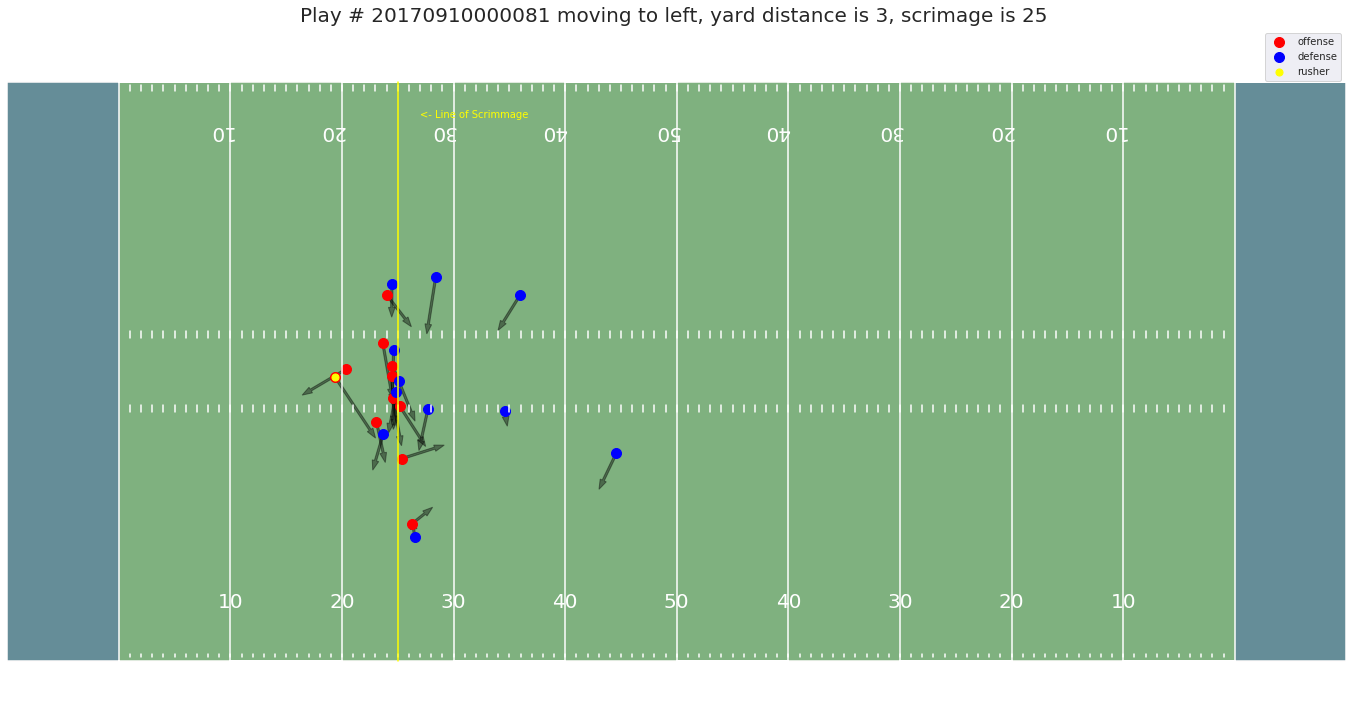

In [180]:
show_play_std(20170910000081, df)

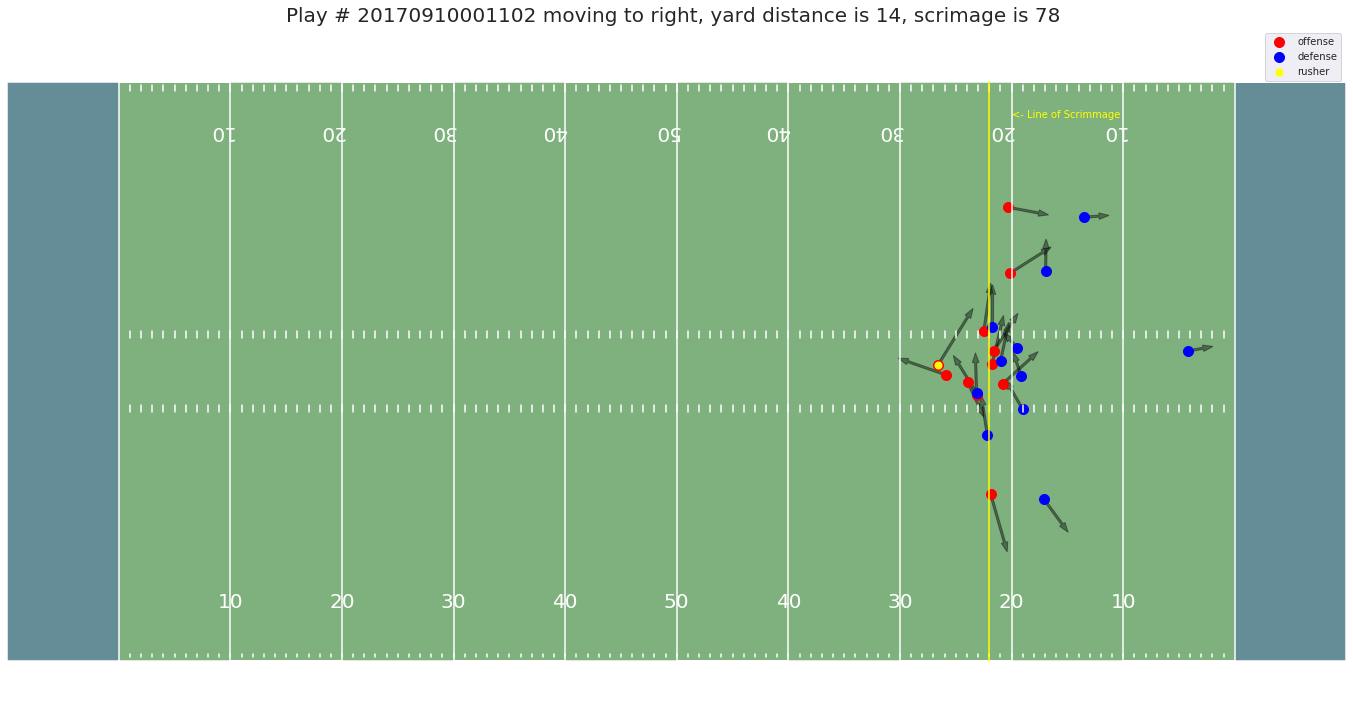

In [181]:
show_play_std(20170910001102, df)

# Get physics features

Use X, Y, direction and weight of players to make new features

Features:
* distance between Runner and QB
* distance from Runner to closest defender
* distance from Runner to defense centroid
* distance from Runner to offense centroid
* distance between offense and defense centroids
* Defense max(X) - min(X)
* Defense X std
* Offense max(X) - min(X)
* Offense X std

In [182]:
import time

In [183]:
def add_play_phys_features(play_id, df=df):
#     step = time.time()
    
    play_index = df['PlayId'] == play_id
    play_df = df[play_index]
    offense_index = (play_index & df.IsOnOffense)
    defense_index = (play_index & ~df.IsOnOffense)
    offense_df = play_df[offense_index]
    defense_df = play_df[defense_index]
    
    offense_spread_x = offense_df.X.max()-offense_df.X.min()
    offense_spread_y = offense_df.Y.max()-offense_df.Y.min()
    offense_centroid_x =  offense_df.X.mean()
    offense_centroid_y =  offense_df.Y.mean()
    offense_x_std = offense_df.X.std()
    offense_y_std = offense_df.Y.std()
    offense_mean_force = offense_df.Force.mean()
    offense_mean_dir = offense_df.Dir.mean()
    
    defense_spread_x = defense_df.X.max()-defense_df.X.min()
    defense_centroid_x =  defense_df.X.mean()
    defense_x_std = defense_df.X.std()
    defense_spread_y = defense_df.Y.max()-defense_df.Y.min()
    defense_centroid_y =  defense_df.Y.mean()
    defense_y_std = defense_df.Y.std()
    defense_mean_force = defense_df.Force.mean()
    defense_mean_dir = defense_df.Dir.mean()
    # Add play features
    new_play_features = pd.DataFrame({
        'offense_spread_x': offense_spread_x, 
        'offense_spread_y': offense_spread_y, 
        'offense_centroid_x': offense_centroid_x, 
        'offense_centroid_y': offense_centroid_y, 
        'offense_x_std': offense_x_std, 
        'offense_y_std': offense_y_std, 
        'offense_mean_force': offense_mean_force, 
        'offense_mean_dir': offense_mean_dir, 
        'defense_spread_x': defense_spread_x, 
        'defense_centroid_x': defense_centroid_x, 
        'defense_x_std': defense_x_std, 
        'defense_spread_y': defense_spread_y, 
        'defense_centroid_y': defense_centroid_y, 
        'defense_y_std': defense_y_std, 
        'defense_mean_force': defense_mean_force, 
        'defense_mean_dir': defense_mean_dir, 
    }, index=play_df.index)

#     df.loc[play_index, new_play_features.columns] = new_play_features.values
    return new_play_features

def add_phys_features(df):
    df['Force'] = df['A']*df['PlayerWeight']
    
    feature_dfs = []
    for play_id in tqdm.tqdm(df.PlayId.unique()):
        feature_dfs.append(add_play_phys_features(play_id, df))
        
    feature_df = pd.concat(feature_dfs)
    
    df_new = pd.concat([df, feature_df], join='inner', axis=1)
    assert df_new.shape[0] == df.shape[0]
    return df_new

df = add_phys_features(df)
df.head(23)





  0%|          | 0/23171 [00:00<?, ?it/s]/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':




  0%|          | 2/23171 [00:00<20:09, 19.16it/s]



  0%|          | 8/23171 [00:00<16:09, 23.89it/s]



  0%|          | 12/23171 [00:00<14:32, 26.55it/s]



  0%|          | 19/23171 [00:00<11:57, 32.27it/s]



  0%|          | 29/23171 [00:00<09:32, 40.43it/s]



  0%|          | 39/23171 [00:00<07:54, 48.72it/s]



  0%|          | 49/23171 [00:00<06:45, 57.09it/s]



  0%|          | 59/23171 [00:00<05:57, 64.71it/s]



  0%|          | 68/23171 [00:00<05:32, 69.53it/s]



  0%|          | 77/23171 [00:01<05:11, 74.23it/s]



  0%|          | 87/23171 [00:01<04:48, 80.02it/s]



  0%|          | 96/23171

  5%|▍         | 1052/23171 [00:13<04:05, 90.24it/s]



  5%|▍         | 1062/23171 [00:13<04:10, 88.39it/s]



  5%|▍         | 1071/23171 [00:13<04:46, 77.15it/s]



  5%|▍         | 1080/23171 [00:14<04:41, 78.40it/s]



  5%|▍         | 1090/23171 [00:14<04:26, 82.88it/s]



  5%|▍         | 1099/23171 [00:14<04:20, 84.72it/s]



  5%|▍         | 1108/23171 [00:14<04:26, 82.90it/s]



  5%|▍         | 1118/23171 [00:14<04:18, 85.42it/s]



  5%|▍         | 1128/23171 [00:14<04:09, 88.39it/s]



  5%|▍         | 1138/23171 [00:14<04:05, 89.61it/s]



  5%|▍         | 1148/23171 [00:14<04:07, 88.83it/s]



  5%|▍         | 1157/23171 [00:14<05:02, 72.76it/s]



  5%|▌         | 1165/23171 [00:15<05:07, 71.50it/s]



  5%|▌         | 1173/23171 [00:15<05:24, 67.72it/s]



  5%|▌         | 1181/23171 [00:15<06:08, 59.63it/s]



  5%|▌         | 1191/23171 [00:15<05:28, 66.91it/s]



  5%|▌         | 1200/23171 [00:15<05:07, 71.48it/s]



  5%|▌         | 1210/23171 [00:15<04:44, 77.11i

  9%|▉         | 2151/23171 [00:27<05:44, 60.94it/s]



  9%|▉         | 2159/23171 [00:27<05:21, 65.43it/s]



  9%|▉         | 2169/23171 [00:28<04:52, 71.71it/s]



  9%|▉         | 2179/23171 [00:28<04:32, 77.01it/s]



  9%|▉         | 2188/23171 [00:28<04:25, 78.89it/s]



  9%|▉         | 2198/23171 [00:28<04:12, 83.08it/s]



 10%|▉         | 2207/23171 [00:28<04:09, 83.87it/s]



 10%|▉         | 2217/23171 [00:28<03:59, 87.44it/s]



 10%|▉         | 2226/23171 [00:28<05:13, 66.78it/s]



 10%|▉         | 2235/23171 [00:28<04:51, 71.79it/s]



 10%|▉         | 2243/23171 [00:28<04:44, 73.56it/s]



 10%|▉         | 2251/23171 [00:29<04:37, 75.37it/s]



 10%|▉         | 2261/23171 [00:29<04:18, 80.77it/s]



 10%|▉         | 2270/23171 [00:29<04:22, 79.48it/s]



 10%|▉         | 2279/23171 [00:29<04:24, 79.02it/s]



 10%|▉         | 2288/23171 [00:29<04:25, 78.69it/s]



 10%|▉         | 2296/23171 [00:29<04:30, 77.22it/s]



 10%|▉         | 2304/23171 [00:29<04:28, 77.63i

 14%|█▍        | 3290/23171 [00:41<03:48, 87.17it/s]



 14%|█▍        | 3299/23171 [00:41<03:53, 85.08it/s]



 14%|█▍        | 3309/23171 [00:41<03:47, 87.21it/s]



 14%|█▍        | 3318/23171 [00:41<03:48, 87.02it/s]



 14%|█▍        | 3327/23171 [00:41<03:48, 86.72it/s]



 14%|█▍        | 3337/23171 [00:41<03:43, 88.77it/s]



 14%|█▍        | 3347/23171 [00:41<03:40, 89.76it/s]



 14%|█▍        | 3357/23171 [00:41<03:40, 89.84it/s]



 15%|█▍        | 3367/23171 [00:41<03:36, 91.45it/s]



 15%|█▍        | 3377/23171 [00:42<03:37, 90.89it/s]



 15%|█▍        | 3387/23171 [00:42<03:38, 90.62it/s]



 15%|█▍        | 3397/23171 [00:42<03:32, 92.90it/s]



 15%|█▍        | 3407/23171 [00:42<03:33, 92.70it/s]



 15%|█▍        | 3417/23171 [00:42<03:32, 92.93it/s]



 15%|█▍        | 3427/23171 [00:42<03:36, 91.26it/s]



 15%|█▍        | 3437/23171 [00:42<03:32, 92.69it/s]



 15%|█▍        | 3447/23171 [00:42<03:33, 92.59it/s]



 15%|█▍        | 3457/23171 [00:42<03:31, 93.15i

 19%|█▉        | 4469/23171 [00:54<03:24, 91.64it/s]



 19%|█▉        | 4479/23171 [00:54<03:28, 89.68it/s]



 19%|█▉        | 4488/23171 [00:54<03:35, 86.65it/s]



 19%|█▉        | 4497/23171 [00:54<03:34, 87.26it/s]



 19%|█▉        | 4506/23171 [00:54<03:33, 87.34it/s]



 19%|█▉        | 4515/23171 [00:54<03:32, 87.99it/s]



 20%|█▉        | 4525/23171 [00:54<03:27, 89.74it/s]



 20%|█▉        | 4534/23171 [00:54<03:28, 89.38it/s]



 20%|█▉        | 4543/23171 [00:54<03:31, 88.13it/s]



 20%|█▉        | 4552/23171 [00:55<03:32, 87.57it/s]



 20%|█▉        | 4562/23171 [00:55<03:28, 89.31it/s]



 20%|█▉        | 4571/23171 [00:55<03:28, 89.08it/s]



 20%|█▉        | 4580/23171 [00:55<03:34, 86.52it/s]



 20%|█▉        | 4590/23171 [00:55<03:30, 88.47it/s]



 20%|█▉        | 4600/23171 [00:55<03:25, 90.16it/s]



 20%|█▉        | 4610/23171 [00:55<03:23, 91.43it/s]



 20%|█▉        | 4620/23171 [00:55<03:24, 90.81it/s]



 20%|█▉        | 4630/23171 [00:55<03:20, 92.45i

 24%|██▍       | 5597/23171 [01:07<03:39, 80.03it/s]



 24%|██▍       | 5606/23171 [01:07<03:41, 79.48it/s]



 24%|██▍       | 5615/23171 [01:07<03:53, 75.23it/s]



 24%|██▍       | 5625/23171 [01:07<03:40, 79.63it/s]



 24%|██▍       | 5634/23171 [01:08<03:35, 81.26it/s]



 24%|██▍       | 5644/23171 [01:08<03:26, 84.90it/s]



 24%|██▍       | 5653/23171 [01:08<03:23, 85.90it/s]



 24%|██▍       | 5662/23171 [01:08<03:30, 83.14it/s]



 24%|██▍       | 5671/23171 [01:08<03:34, 81.54it/s]



 25%|██▍       | 5680/23171 [01:08<03:32, 82.45it/s]



 25%|██▍       | 5689/23171 [01:08<03:31, 82.62it/s]



 25%|██▍       | 5698/23171 [01:08<03:26, 84.67it/s]



 25%|██▍       | 5707/23171 [01:08<03:27, 84.29it/s]



 25%|██▍       | 5716/23171 [01:09<03:26, 84.58it/s]



 25%|██▍       | 5725/23171 [01:09<03:44, 77.81it/s]



 25%|██▍       | 5733/23171 [01:09<03:56, 73.60it/s]



 25%|██▍       | 5741/23171 [01:09<04:00, 72.34it/s]



 25%|██▍       | 5752/23171 [01:09<03:40, 79.14i

 29%|██▉       | 6662/23171 [01:20<05:00, 55.02it/s]



 29%|██▉       | 6669/23171 [01:21<04:44, 58.00it/s]



 29%|██▉       | 6677/23171 [01:21<04:23, 62.49it/s]



 29%|██▉       | 6686/23171 [01:21<04:06, 67.01it/s]



 29%|██▉       | 6695/23171 [01:21<03:50, 71.39it/s]



 29%|██▉       | 6704/23171 [01:21<03:41, 74.42it/s]



 29%|██▉       | 6714/23171 [01:21<03:28, 79.12it/s]



 29%|██▉       | 6723/23171 [01:21<04:32, 60.26it/s]



 29%|██▉       | 6730/23171 [01:22<06:18, 43.42it/s]



 29%|██▉       | 6736/23171 [01:22<05:51, 46.74it/s]



 29%|██▉       | 6742/23171 [01:22<05:42, 47.92it/s]



 29%|██▉       | 6748/23171 [01:22<05:35, 48.99it/s]



 29%|██▉       | 6754/23171 [01:22<05:59, 45.70it/s]



 29%|██▉       | 6760/23171 [01:22<05:39, 48.35it/s]



 29%|██▉       | 6766/23171 [01:22<05:34, 49.04it/s]



 29%|██▉       | 6772/23171 [01:22<05:16, 51.79it/s]



 29%|██▉       | 6778/23171 [01:23<05:11, 52.54it/s]



 29%|██▉       | 6784/23171 [01:23<05:00, 54.53i

 32%|███▏      | 7452/23171 [01:35<03:12, 81.55it/s]



 32%|███▏      | 7461/23171 [01:35<03:07, 83.60it/s]



 32%|███▏      | 7471/23171 [01:35<02:59, 87.65it/s]



 32%|███▏      | 7481/23171 [01:35<02:55, 89.54it/s]



 32%|███▏      | 7491/23171 [01:35<03:07, 83.66it/s]



 32%|███▏      | 7500/23171 [01:35<03:23, 77.02it/s]



 32%|███▏      | 7508/23171 [01:36<04:04, 64.06it/s]



 32%|███▏      | 7515/23171 [01:36<04:21, 59.76it/s]



 32%|███▏      | 7524/23171 [01:36<03:58, 65.48it/s]



 33%|███▎      | 7531/23171 [01:36<04:02, 64.43it/s]



 33%|███▎      | 7539/23171 [01:36<03:50, 67.88it/s]



 33%|███▎      | 7549/23171 [01:36<03:28, 74.83it/s]



 33%|███▎      | 7557/23171 [01:36<03:28, 75.06it/s]



 33%|███▎      | 7565/23171 [01:36<03:37, 71.76it/s]



 33%|███▎      | 7573/23171 [01:37<03:51, 67.29it/s]



 33%|███▎      | 7580/23171 [01:37<03:49, 68.05it/s]



 33%|███▎      | 7588/23171 [01:37<03:39, 71.04it/s]



 33%|███▎      | 7596/23171 [01:37<03:32, 73.44i

 36%|███▌      | 8392/23171 [01:49<05:30, 44.66it/s]



 36%|███▌      | 8397/23171 [01:50<05:57, 41.34it/s]



 36%|███▋      | 8402/23171 [01:50<06:07, 40.21it/s]



 36%|███▋      | 8408/23171 [01:50<05:37, 43.74it/s]



 36%|███▋      | 8413/23171 [01:50<06:01, 40.84it/s]



 36%|███▋      | 8418/23171 [01:50<06:29, 37.87it/s]



 36%|███▋      | 8422/23171 [01:50<06:26, 38.20it/s]



 36%|███▋      | 8426/23171 [01:50<07:29, 32.83it/s]



 36%|███▋      | 8430/23171 [01:50<07:49, 31.40it/s]



 36%|███▋      | 8434/23171 [01:51<07:51, 31.23it/s]



 36%|███▋      | 8438/23171 [01:51<07:46, 31.58it/s]



 36%|███▋      | 8442/23171 [01:51<07:41, 31.93it/s]



 36%|███▋      | 8446/23171 [01:51<08:02, 30.53it/s]



 36%|███▋      | 8450/23171 [01:51<08:13, 29.80it/s]



 36%|███▋      | 8454/23171 [01:51<08:20, 29.38it/s]



 37%|███▋      | 8459/23171 [01:51<07:31, 32.59it/s]



 37%|███▋      | 8463/23171 [01:52<07:18, 33.55it/s]



 37%|███▋      | 8467/23171 [01:52<07:29, 32.68i

 39%|███▉      | 9105/23171 [02:04<04:14, 55.27it/s]



 39%|███▉      | 9112/23171 [02:05<04:23, 53.34it/s]



 39%|███▉      | 9121/23171 [02:05<03:55, 59.74it/s]



 39%|███▉      | 9130/23171 [02:05<03:34, 65.57it/s]



 39%|███▉      | 9138/23171 [02:05<03:29, 66.92it/s]



 39%|███▉      | 9146/23171 [02:05<03:43, 62.81it/s]



 40%|███▉      | 9153/23171 [02:05<03:46, 61.76it/s]



 40%|███▉      | 9160/23171 [02:05<03:57, 59.06it/s]



 40%|███▉      | 9167/23171 [02:05<04:03, 57.41it/s]



 40%|███▉      | 9173/23171 [02:06<04:03, 57.56it/s]



 40%|███▉      | 9179/23171 [02:06<04:10, 55.97it/s]



 40%|███▉      | 9185/23171 [02:06<04:15, 54.65it/s]



 40%|███▉      | 9191/23171 [02:06<04:11, 55.65it/s]



 40%|███▉      | 9198/23171 [02:06<04:02, 57.56it/s]



 40%|███▉      | 9206/23171 [02:06<03:42, 62.73it/s]



 40%|███▉      | 9215/23171 [02:06<03:25, 67.81it/s]



 40%|███▉      | 9223/23171 [02:06<03:16, 70.82it/s]



 40%|███▉      | 9231/23171 [02:06<03:32, 65.51i

 43%|████▎     | 10074/23171 [02:19<02:38, 82.81it/s]



 44%|████▎     | 10083/23171 [02:19<02:36, 83.84it/s]



 44%|████▎     | 10092/23171 [02:19<02:33, 85.27it/s]



 44%|████▎     | 10101/23171 [02:19<02:44, 79.66it/s]



 44%|████▎     | 10111/23171 [02:19<02:36, 83.23it/s]



 44%|████▎     | 10121/23171 [02:19<02:30, 86.90it/s]



 44%|████▎     | 10131/23171 [02:19<02:26, 89.21it/s]



 44%|████▍     | 10141/23171 [02:19<02:24, 89.98it/s]



 44%|████▍     | 10151/23171 [02:19<02:24, 90.39it/s]



 44%|████▍     | 10161/23171 [02:20<02:27, 88.19it/s]



 44%|████▍     | 10171/23171 [02:20<02:23, 90.63it/s]



 44%|████▍     | 10181/23171 [02:20<02:25, 89.33it/s]



 44%|████▍     | 10190/23171 [02:20<02:27, 88.29it/s]



 44%|████▍     | 10199/23171 [02:20<02:42, 80.07it/s]



 44%|████▍     | 10208/23171 [02:20<03:22, 63.96it/s]



 44%|████▍     | 10216/23171 [02:20<03:25, 63.00it/s]



 44%|████▍     | 10223/23171 [02:20<03:20, 64.61it/s]



 44%|████▍     | 10230/23171 [0

 48%|████▊     | 11089/23171 [02:32<02:58, 67.80it/s]



 48%|████▊     | 11097/23171 [02:32<02:52, 70.04it/s]



 48%|████▊     | 11105/23171 [02:32<02:45, 72.72it/s]



 48%|████▊     | 11115/23171 [02:32<02:35, 77.69it/s]



 48%|████▊     | 11124/23171 [02:32<02:29, 80.63it/s]



 48%|████▊     | 11133/23171 [02:33<02:25, 82.78it/s]



 48%|████▊     | 11143/23171 [02:33<02:20, 85.91it/s]



 48%|████▊     | 11153/23171 [02:33<02:15, 88.75it/s]



 48%|████▊     | 11162/23171 [02:33<02:25, 82.34it/s]



 48%|████▊     | 11171/23171 [02:33<02:25, 82.40it/s]



 48%|████▊     | 11180/23171 [02:33<02:50, 70.15it/s]



 48%|████▊     | 11188/23171 [02:33<02:52, 69.58it/s]



 48%|████▊     | 11196/23171 [02:33<03:07, 63.85it/s]



 48%|████▊     | 11203/23171 [02:34<03:18, 60.24it/s]



 48%|████▊     | 11210/23171 [02:34<03:10, 62.77it/s]



 48%|████▊     | 11217/23171 [02:34<03:26, 57.95it/s]



 48%|████▊     | 11224/23171 [02:34<03:44, 53.23it/s]



 48%|████▊     | 11230/23171 [0

 52%|█████▏    | 12160/23171 [02:45<02:20, 78.59it/s]



 53%|█████▎    | 12169/23171 [02:45<02:16, 80.81it/s]



 53%|█████▎    | 12178/23171 [02:46<02:14, 81.63it/s]



 53%|█████▎    | 12187/23171 [02:46<02:12, 82.86it/s]



 53%|█████▎    | 12196/23171 [02:46<02:09, 84.73it/s]



 53%|█████▎    | 12206/23171 [02:46<02:06, 86.89it/s]



 53%|█████▎    | 12215/23171 [02:46<02:07, 85.85it/s]



 53%|█████▎    | 12225/23171 [02:46<02:04, 88.09it/s]



 53%|█████▎    | 12234/23171 [02:46<02:06, 86.46it/s]



 53%|█████▎    | 12243/23171 [02:46<02:04, 87.48it/s]



 53%|█████▎    | 12253/23171 [02:46<02:03, 88.71it/s]



 53%|█████▎    | 12262/23171 [02:46<02:06, 86.02it/s]



 53%|█████▎    | 12271/23171 [02:47<02:08, 84.71it/s]



 53%|█████▎    | 12281/23171 [02:47<02:05, 86.74it/s]



 53%|█████▎    | 12290/23171 [02:47<02:08, 84.93it/s]



 53%|█████▎    | 12299/23171 [02:47<02:07, 85.32it/s]



 53%|█████▎    | 12308/23171 [02:47<02:09, 83.66it/s]



 53%|█████▎    | 12317/23171 [0

 57%|█████▋    | 13221/23171 [02:58<01:59, 83.12it/s]



 57%|█████▋    | 13230/23171 [02:58<02:03, 80.53it/s]



 57%|█████▋    | 13240/23171 [02:59<01:57, 84.23it/s]



 57%|█████▋    | 13249/23171 [02:59<01:56, 85.24it/s]



 57%|█████▋    | 13258/23171 [02:59<02:09, 76.41it/s]



 57%|█████▋    | 13267/23171 [02:59<02:05, 79.14it/s]



 57%|█████▋    | 13276/23171 [02:59<02:01, 81.37it/s]



 57%|█████▋    | 13285/23171 [02:59<01:59, 82.97it/s]



 57%|█████▋    | 13294/23171 [02:59<01:58, 83.45it/s]



 57%|█████▋    | 13303/23171 [02:59<02:01, 81.41it/s]



 57%|█████▋    | 13312/23171 [02:59<02:05, 78.55it/s]



 57%|█████▋    | 13320/23171 [03:00<02:10, 75.66it/s]



 58%|█████▊    | 13328/23171 [03:00<02:10, 75.47it/s]



 58%|█████▊    | 13336/23171 [03:00<02:13, 73.90it/s]



 58%|█████▊    | 13344/23171 [03:00<02:17, 71.70it/s]



 58%|█████▊    | 13352/23171 [03:00<02:25, 67.47it/s]



 58%|█████▊    | 13360/23171 [03:00<02:21, 69.39it/s]



 58%|█████▊    | 13368/23171 [0

 61%|██████    | 14137/23171 [03:12<02:20, 64.21it/s]



 61%|██████    | 14145/23171 [03:12<02:12, 68.03it/s]



 61%|██████    | 14153/23171 [03:13<02:18, 64.90it/s]



 61%|██████    | 14160/23171 [03:13<02:20, 64.11it/s]



 61%|██████    | 14167/23171 [03:13<02:19, 64.49it/s]



 61%|██████    | 14176/23171 [03:13<02:08, 69.79it/s]



 61%|██████    | 14184/23171 [03:13<02:11, 68.18it/s]



 61%|██████    | 14191/23171 [03:13<02:14, 66.83it/s]



 61%|██████▏   | 14199/23171 [03:13<02:11, 68.18it/s]



 61%|██████▏   | 14206/23171 [03:13<02:20, 63.70it/s]



 61%|██████▏   | 14213/23171 [03:14<02:19, 64.23it/s]



 61%|██████▏   | 14223/23171 [03:14<02:06, 70.64it/s]



 61%|██████▏   | 14233/23171 [03:14<01:57, 76.33it/s]



 61%|██████▏   | 14242/23171 [03:14<01:51, 79.89it/s]



 62%|██████▏   | 14251/23171 [03:14<01:48, 82.55it/s]



 62%|██████▏   | 14260/23171 [03:14<01:45, 84.58it/s]



 62%|██████▏   | 14270/23171 [03:14<01:42, 87.04it/s]



 62%|██████▏   | 14279/23171 [0

 66%|██████▌   | 15196/23171 [03:26<01:21, 98.26it/s]



 66%|██████▌   | 15208/23171 [03:26<01:18, 101.74it/s]



 66%|██████▌   | 15219/23171 [03:26<01:17, 103.08it/s]



 66%|██████▌   | 15230/23171 [03:26<01:15, 104.62it/s]



 66%|██████▌   | 15241/23171 [03:26<01:16, 103.35it/s]



 66%|██████▌   | 15252/23171 [03:27<01:17, 102.51it/s]



 66%|██████▌   | 15263/23171 [03:27<01:26, 91.79it/s] 



 66%|██████▌   | 15273/23171 [03:27<01:31, 86.42it/s]



 66%|██████▌   | 15284/23171 [03:27<01:26, 90.89it/s]



 66%|██████▌   | 15294/23171 [03:27<01:25, 91.81it/s]



 66%|██████▌   | 15305/23171 [03:27<01:22, 95.39it/s]



 66%|██████▌   | 15317/23171 [03:27<01:18, 99.58it/s]



 66%|██████▌   | 15329/23171 [03:27<01:16, 102.88it/s]



 66%|██████▌   | 15340/23171 [03:27<01:14, 104.58it/s]



 66%|██████▋   | 15351/23171 [03:28<01:14, 104.48it/s]



 66%|██████▋   | 15362/23171 [03:28<01:14, 104.99it/s]



 66%|██████▋   | 15374/23171 [03:28<01:13, 106.11it/s]



 66%|██████▋   | 153

 70%|███████   | 16322/23171 [03:40<01:46, 64.13it/s]



 70%|███████   | 16329/23171 [03:40<01:44, 65.52it/s]



 71%|███████   | 16338/23171 [03:40<01:38, 69.18it/s]



 71%|███████   | 16346/23171 [03:40<01:35, 71.29it/s]



 71%|███████   | 16354/23171 [03:40<01:47, 63.45it/s]



 71%|███████   | 16361/23171 [03:41<01:46, 64.10it/s]



 71%|███████   | 16368/23171 [03:41<01:44, 65.09it/s]



 71%|███████   | 16377/23171 [03:41<01:37, 69.74it/s]



 71%|███████   | 16385/23171 [03:41<01:35, 71.03it/s]



 71%|███████   | 16393/23171 [03:41<01:35, 71.15it/s]



 71%|███████   | 16401/23171 [03:41<01:46, 63.85it/s]



 71%|███████   | 16408/23171 [03:41<01:48, 62.39it/s]



 71%|███████   | 16415/23171 [03:41<01:49, 61.91it/s]



 71%|███████   | 16423/23171 [03:41<01:43, 65.09it/s]



 71%|███████   | 16431/23171 [03:42<01:38, 68.52it/s]



 71%|███████   | 16438/23171 [03:42<01:38, 68.40it/s]



 71%|███████   | 16447/23171 [03:42<01:34, 70.83it/s]



 71%|███████   | 16455/23171 [0

 74%|███████▍  | 17162/23171 [03:54<01:20, 74.40it/s]



 74%|███████▍  | 17173/23171 [03:55<01:13, 81.96it/s]



 74%|███████▍  | 17184/23171 [03:55<01:08, 87.52it/s]



 74%|███████▍  | 17195/23171 [03:55<01:04, 93.13it/s]



 74%|███████▍  | 17206/23171 [03:55<01:02, 95.52it/s]



 74%|███████▍  | 17216/23171 [03:55<01:02, 95.54it/s]



 74%|███████▍  | 17227/23171 [03:55<01:01, 97.43it/s]



 74%|███████▍  | 17238/23171 [03:55<00:59, 98.99it/s]



 74%|███████▍  | 17249/23171 [03:55<00:58, 101.32it/s]



 74%|███████▍  | 17260/23171 [03:55<00:57, 102.44it/s]



 75%|███████▍  | 17272/23171 [03:55<00:56, 104.99it/s]



 75%|███████▍  | 17283/23171 [03:56<00:55, 106.37it/s]



 75%|███████▍  | 17294/23171 [03:56<01:04, 91.79it/s] 



 75%|███████▍  | 17304/23171 [03:56<01:11, 82.57it/s]



 75%|███████▍  | 17315/23171 [03:56<01:06, 88.36it/s]



 75%|███████▍  | 17326/23171 [03:56<01:02, 93.58it/s]



 75%|███████▍  | 17337/23171 [03:56<01:00, 96.37it/s]



 75%|███████▍  | 17348/231

 80%|███████▉  | 18448/23171 [04:08<00:59, 79.48it/s]



 80%|███████▉  | 18459/23171 [04:08<00:54, 86.45it/s]



 80%|███████▉  | 18470/23171 [04:08<00:51, 91.47it/s]



 80%|███████▉  | 18481/23171 [04:08<00:48, 96.08it/s]



 80%|███████▉  | 18493/23171 [04:08<00:46, 100.12it/s]



 80%|███████▉  | 18505/23171 [04:08<00:45, 103.24it/s]



 80%|███████▉  | 18516/23171 [04:08<00:44, 105.15it/s]



 80%|███████▉  | 18527/23171 [04:08<00:43, 106.28it/s]



 80%|████████  | 18539/23171 [04:08<00:43, 107.52it/s]



 80%|████████  | 18551/23171 [04:09<00:42, 108.65it/s]



 80%|████████  | 18563/23171 [04:09<00:42, 109.20it/s]



 80%|████████  | 18574/23171 [04:09<00:42, 107.29it/s]



 80%|████████  | 18585/23171 [04:09<00:42, 107.94it/s]



 80%|████████  | 18596/23171 [04:09<00:42, 107.24it/s]



 80%|████████  | 18607/23171 [04:09<00:42, 107.34it/s]



 80%|████████  | 18619/23171 [04:09<00:41, 108.58it/s]



 80%|████████  | 18631/23171 [04:09<00:41, 108.97it/s]



 80%|████████  | 1

 85%|████████▍ | 19669/23171 [04:21<00:55, 63.31it/s]



 85%|████████▍ | 19676/23171 [04:21<01:00, 57.30it/s]



 85%|████████▍ | 19683/23171 [04:21<01:00, 58.00it/s]



 85%|████████▍ | 19690/23171 [04:21<00:58, 59.82it/s]



 85%|████████▌ | 19697/23171 [04:21<00:57, 60.41it/s]



 85%|████████▌ | 19704/23171 [04:21<00:56, 61.43it/s]



 85%|████████▌ | 19711/23171 [04:22<00:54, 63.28it/s]



 85%|████████▌ | 19718/23171 [04:22<00:54, 63.73it/s]



 85%|████████▌ | 19725/23171 [04:22<00:56, 61.28it/s]



 85%|████████▌ | 19735/23171 [04:22<00:49, 69.31it/s]



 85%|████████▌ | 19743/23171 [04:22<00:47, 71.50it/s]



 85%|████████▌ | 19752/23171 [04:22<00:45, 74.47it/s]



 85%|████████▌ | 19761/23171 [04:22<00:43, 77.77it/s]



 85%|████████▌ | 19771/23171 [04:22<00:41, 81.94it/s]



 85%|████████▌ | 19782/23171 [04:22<00:38, 87.64it/s]



 85%|████████▌ | 19793/23171 [04:23<00:37, 90.52it/s]



 85%|████████▌ | 19804/23171 [04:23<00:35, 93.68it/s]



 86%|████████▌ | 19815/23171 [0

 90%|█████████ | 20920/23171 [04:33<00:26, 85.05it/s] 



 90%|█████████ | 20931/23171 [04:33<00:24, 90.04it/s]



 90%|█████████ | 20942/23171 [04:33<00:24, 92.77it/s]



 90%|█████████ | 20952/23171 [04:33<00:24, 92.27it/s]



 90%|█████████ | 20964/23171 [04:34<00:22, 97.08it/s]



 91%|█████████ | 20975/23171 [04:34<00:22, 99.00it/s]



 91%|█████████ | 20986/23171 [04:34<00:21, 100.28it/s]



 91%|█████████ | 20998/23171 [04:34<00:20, 103.50it/s]



 91%|█████████ | 21009/23171 [04:34<00:20, 104.75it/s]



 91%|█████████ | 21021/23171 [04:34<00:20, 106.55it/s]



 91%|█████████ | 21032/23171 [04:34<00:20, 102.83it/s]



 91%|█████████ | 21043/23171 [04:34<00:20, 102.82it/s]



 91%|█████████ | 21054/23171 [04:35<00:24, 84.86it/s] 



 91%|█████████ | 21064/23171 [04:35<00:28, 74.76it/s]



 91%|█████████ | 21073/23171 [04:35<00:31, 66.71it/s]



 91%|█████████ | 21081/23171 [04:35<00:30, 69.26it/s]



 91%|█████████ | 21089/23171 [04:35<00:30, 69.20it/s]



 91%|█████████ | 21097/

 95%|█████████▍| 21965/23171 [04:47<00:16, 71.25it/s]



 95%|█████████▍| 21973/23171 [04:47<00:17, 68.96it/s]



 95%|█████████▍| 21981/23171 [04:47<00:16, 71.66it/s]



 95%|█████████▍| 21989/23171 [04:47<00:16, 72.91it/s]



 95%|█████████▍| 21997/23171 [04:47<00:15, 73.89it/s]



 95%|█████████▍| 22005/23171 [04:47<00:15, 74.54it/s]



 95%|█████████▌| 22013/23171 [04:48<00:15, 73.13it/s]



 95%|█████████▌| 22021/23171 [04:48<00:15, 74.70it/s]



 95%|█████████▌| 22029/23171 [04:48<00:15, 75.37it/s]



 95%|█████████▌| 22037/23171 [04:48<00:15, 75.54it/s]



 95%|█████████▌| 22045/23171 [04:48<00:15, 73.39it/s]



 95%|█████████▌| 22053/23171 [04:48<00:15, 74.39it/s]



 95%|█████████▌| 22061/23171 [04:48<00:15, 73.18it/s]



 95%|█████████▌| 22070/23171 [04:48<00:14, 76.24it/s]



 95%|█████████▌| 22078/23171 [04:48<00:14, 75.14it/s]



 95%|█████████▌| 22087/23171 [04:48<00:13, 78.25it/s]



 95%|█████████▌| 22095/23171 [04:49<00:14, 75.69it/s]



 95%|█████████▌| 22103/23171 [0

 99%|█████████▉| 22950/23171 [05:00<00:02, 80.55it/s]



 99%|█████████▉| 22959/23171 [05:00<00:02, 75.96it/s]



 99%|█████████▉| 22968/23171 [05:00<00:02, 78.36it/s]



 99%|█████████▉| 22978/23171 [05:00<00:02, 82.48it/s]



 99%|█████████▉| 22987/23171 [05:00<00:02, 83.36it/s]



 99%|█████████▉| 22997/23171 [05:00<00:02, 86.09it/s]



 99%|█████████▉| 23006/23171 [05:00<00:01, 85.65it/s]



 99%|█████████▉| 23015/23171 [05:00<00:01, 84.50it/s]



 99%|█████████▉| 23025/23171 [05:01<00:01, 86.93it/s]



 99%|█████████▉| 23035/23171 [05:01<00:01, 88.62it/s]



 99%|█████████▉| 23045/23171 [05:01<00:01, 90.64it/s]



 99%|█████████▉| 23055/23171 [05:01<00:01, 89.00it/s]



100%|█████████▉| 23065/23171 [05:01<00:01, 90.63it/s]



100%|█████████▉| 23075/23171 [05:01<00:01, 91.64it/s]



100%|█████████▉| 23085/23171 [05:01<00:00, 93.25it/s]



100%|█████████▉| 23095/23171 [05:01<00:00, 91.26it/s]



100%|█████████▉| 23105/23171 [05:01<00:00, 91.81it/s]



100%|█████████▉| 23115/23171 [0

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,GameWeather,Temperature,Humidity,WindSpeed,ToLeft,TeamOnOffense,IsOnOffense,HomeOnOffense,TurfIsNatural,StadiumTypeShort,HomeField,Field_eq_Possession,HomePossesion,OffenseFormation_ACE,OffenseFormation_EMPTY,OffenseFormation_I_FORM,OffenseFormation_JUMBO,OffenseFormation_PISTOL,OffenseFormation_SHOTGUN,OffenseFormation_SINGLEBACK,OffenseFormation_WILDCAT,PlayerBMI,TimeDelta,PlayerAge,IsRusher,defense_DB,defense_DL,defense_LB,defense_OL,defense_QB,defense_RB,defense_TE,defense_WR,offense_DB,offense_DL,offense_LB,offense_OL,offense_QB,offense_RB,offense_TE,offense_WR,DefendersInTheBox_vs_Distance,Force,offense_spread_x,offense_spread_y,offense_centroid_x,offense_centroid_y,offense_x_std,offense_y_std,offense_mean_force,offense_mean_dir,defense_spread_x,defense_centroid_x,defense_x_std,defense_spread_y,defense_centroid_y,defense_y_std,defense_mean_force,defense_mean_dir
0,2017090700,20170907000118,away,46.09,18.493333,1.69,1.13,0.40,4.572588,1.620015,496723,Eric Berry,29,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,1988-12-29 00:00:00+00:00,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,28.749228,1.0,28.692760,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0,239.56,5.18,19.35,44.057273,24.797879,1.772665,5.855606,339.667273,1.861774,18.43,48.179091,5.294079,22.19,24.442424,7.014714,233.012727,3.163028
1,2017090700,20170907000118,away,45.33,20.693333,0.42,1.35,0.01,3.623478,1.244420,2495116,Allen Bailey,97,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,1989-03-25 00:00:00+00:00,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,35.993600,1.0,28.457305,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0,388.80,5.18,19.35,44.057273,24.797879,1.772665,5.855606,339.667273,1.861774,18.43,48.179091,5.294079,22.19,24.442424,7.014714,233.012727,3.163028
2,2017090700,20170907000118,away,46.00,20.133333,1.22,0.59,0.31,3.194127,1.174083,2495493,Justin Houston,50,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,1989-01-21 00:00:00+00:00,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,33.744000,1.0,28.629790,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0,159.30,5.18,19.35,44.057273,24.797879,1.772665,5.855606,339.667273,1.861774,18.43,48.179091,5.294079,22.19,24.442424,7.014714,233.012727,3.163028
3,2017090700,20170907000118,away,48.54,25.633333,0.42,0.54,0.02,3.137578,2.868623,2506353,Derrick Johnson,56,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,1982-11-22 00:00:00+00:00,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,30.619556,1.0,34.795430,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0,132.30,5.18,19.35,44.057273,24.797879,1.772665,5.855606,339.667273,1.861774,18.43,48.179091,5.294079,22.19,24.442424,7.014714,233.012727,3.163028
4,2017090700,20170907000118,away,50.68,17.913333,1.82,2.43,0.16,3.362028,1.844638,2530794,Ron Parker,38,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,1987-08-17 00:00:00+00:00,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,27.935571,1.0,30.061685,False,6

In [223]:
df['Position'] == 'QB'

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15         True
16        False
17        False
19        False
20        False
21        False
18        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
30        False
31        False
32        False
33        False
34        False
35        False
36        False
37         True
38        False
39        False
41        False
42        False
43        False
40        False
44        False
45        False
46        False
47        False
48        False
49        False
50        False
51        False
52        False
53        False
54        False
55        False
56        False
57        False
58        False
59         True
60        False
61        False
63      

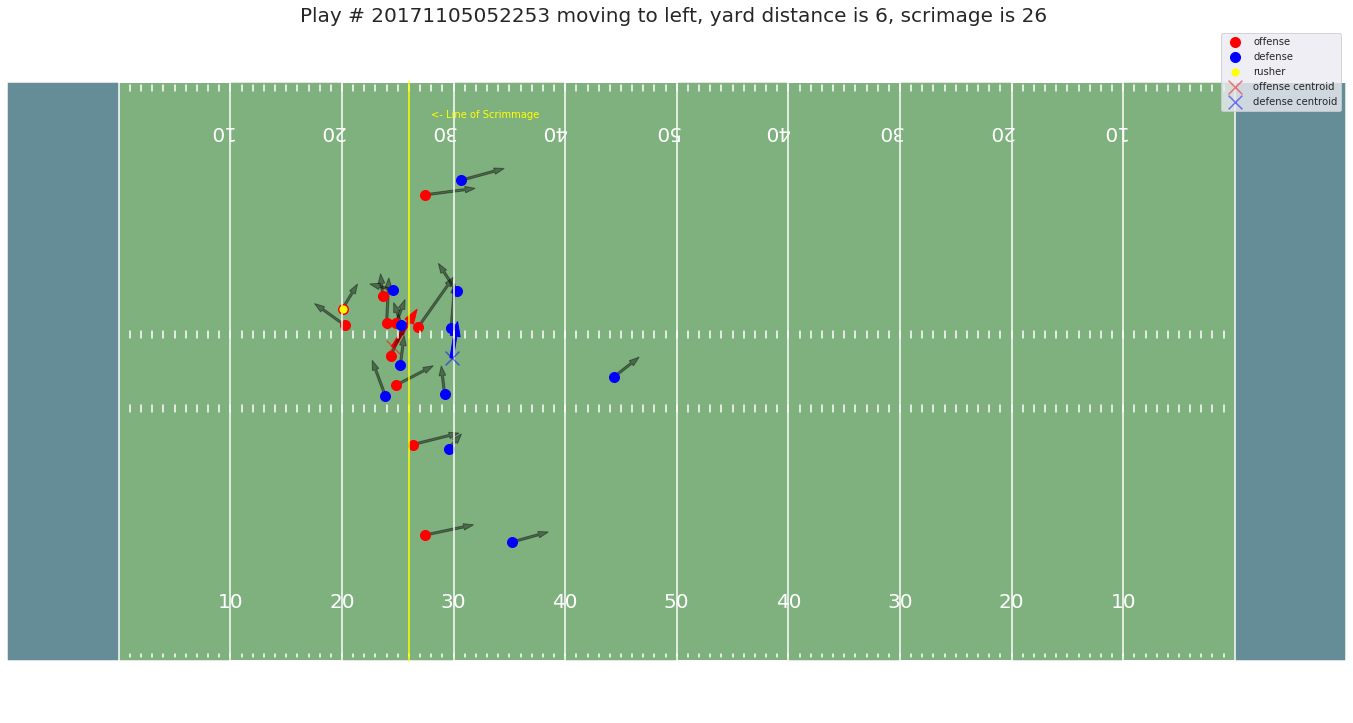

In [221]:
def show_play_phys_features(play_id, train):
    df = train[train.PlayId == play_id]
    YardLine = df.YardLine.values[0]
    fig, ax = create_football_field(highlight_line=True,
                                    highlight_line_number=YardLine,
                                   )
    
    ax.scatter(df[df.IsOnOffense].X, df[df.IsOnOffense].Y, color='red', s=100, label='offense')
    ax.scatter(df[~df.IsOnOffense].X, df[~df.IsOnOffense].Y, color='blue', s=100, label='defense')
    rusher_row = df[df.IsRusher]
    ax.scatter(rusher_row.X, rusher_row.Y, color='yellow', s=50, label='rusher', zorder=999)
    yards_covered = rusher_row["Yards"].values[0]
    
    
    # Phys features
    of_centr_x, of_centr_y = df.iloc[0].offense_centroid_x, df.iloc[0].offense_centroid_y
    of_mean_dir = df.iloc[0].offense_mean_dir
    ax.scatter(of_centr_x, of_centr_y, color='red', s=190, marker='x', label='offense centroid', alpha=0.5, zorder=999)
    
    # offense vector
    dx, dy = get_dx_dy(of_mean_dir, df[df.IsOnOffense].S.mean())
    ax.arrow(of_centr_x, of_centr_y, dx, dy, length_includes_head=False, width=0.3, color='red', alpha=1, zorder=0)
        
    def_centr_x, def_centr_y = df.iloc[0].defense_centroid_x, df.iloc[0].defense_centroid_y
    def_mean_dir = df.iloc[0].defense_mean_dir
    ax.scatter(def_centr_x, def_centr_y, color='blue', s=190, marker='x', label='defense centroid', alpha=0.5, zorder=999)
    
    # defense vector
    dx, dy = get_dx_dy(def_mean_dir, df[~df.IsOnOffense].S.mean())
    ax.arrow(def_centr_x, def_centr_y, dx, dy, length_includes_head=False, width=0.3, color='blue', alpha=1, zorder=0)
        
    
    for (x, y, Dir, S) in zip(df.X, df.Y, df.Dir, df.S):       
        dx, dy = get_dx_dy(Dir, S)
        ax.arrow(x, y, dx, dy, length_includes_head=False, width=0.2, color='black', alpha=0.4, zorder=0)
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}, scrimage is {YardLine} ', fontsize=20)
    plt.legend()
    plt.show()
    
show_play_phys_features(df.PlayId.sample(1).values[0], df)

# Physx features 2
* min time to tackle runner
* runner speed vs closest defender speed
* runner speed vs average defenders speed
* scalar product between runner mov vector and closest defender mov vector
* scalar product between runner mov vector and average defenders mov vector
force(speed*mass):
* runner force vs closest defender force
* runner force vs average defender force

In [15]:
play_id = 20170910001102
play_df = df[df['PlayId'] == play_id]
offense_df = play_df[play_df.IsOnOffense]
defense_df = play_df[~play_df.IsOnOffense]

rusher_row = offense_df[offense_df.IsRusher == True].iloc[0]
qb_row = offense_df[offense_df.Position == 'QB'].iloc[0]

offense_centroid_pos = np.array([offense_centroid_x, offense_centroid_y])
defense_centroid_pos = np.array([defense_centroid_x, defense_centroid_y])
rusher_pos = rusher_row[['X', 'Y']].values[0]
qb_pos = qb_row[['X', 'Y']].values[0]

# Defender to rusher distances
defense_distances_to_runner = []
for row in defense_df.itertuples():
    pos = np.array([row.X, row.Y])
    defense_distances_to_runner.append(np.linalg.norm(rusher_pos-pos))
dist_to_rusher = defense_distances_to_runner = np.array(defense_distances_to_runner)

time_to_rusher = defense_df['S'] / dist_to_rusher

defender_dist_to_runner_min = defense_distances_to_runner.min()
defender_dist_to_runner_mean = defense_distances_to_runner.mean()
defender_dist_to_runner_std = defense_distances_to_runner.std()

defender_time_to_runner_min = time_to_rusher.min()
defender_time_to_runner_mean = time_to_rusher.mean()

# closest defenders
closest_defender = defense_df[dist_to_rusher == defender_dist_to_runner_min].iloc[0]
closest_bytime_defender = defense_df[time_to_rusher == defender_time_to_runner_min].iloc[0]

closest_defender_force_div_rusher_force = (closest_defender.Force/rusher_row.Force)
closest_bytime_defender_force_div_rusher_force = (closest_bytime_defender.Force/rusher_row.Force)

closest_bytime_defender_speed_div_rusher_speed = closest_bytime_defender.S/rusher_row.S
closest_bytime_defender_acceleration_div_rusher_acceleration = closest_bytime_defender.A/rusher_row.A

# Rusher distances
rusher_dist_to_qb = np.linalg.norm(rusher_pos-qb_pos)
rusher_dist_to_offense_centroid = np.linalg.norm(rusher_pos-offense_centroid_pos)
rusher_dist_to_defence_centroid = np.linalg.norm(rusher_pos-defense_centroid_pos)

closest_defender_force_div_rusher_force, closest_bytime_defender_force_div_rusher_force

(0.23555555555555557, 0.03872672672672673)

In [225]:
for playid in df.PlayId.unique():
    play_index = df['PlayId'] == play_id
    play_df = df[play_index]
    offense_index = (play_index & df.IsOnOffense)
    defense_index = (play_index & ~df.IsOnOffense)
    offense_df = play_df[offense_index]
    defense_df = play_df[defense_index]
    rusher_row = offense_df[offense_df.IsRusher].iloc[0]

/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


KeyboardInterrupt: 

In [234]:
df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,GameWeather,Temperature,Humidity,WindSpeed,ToLeft,TeamOnOffense,IsOnOffense,HomeOnOffense,TurfIsNatural,StadiumTypeShort,HomeField,Field_eq_Possession,HomePossesion,OffenseFormation_ACE,OffenseFormation_EMPTY,OffenseFormation_I_FORM,OffenseFormation_JUMBO,OffenseFormation_PISTOL,OffenseFormation_SHOTGUN,OffenseFormation_SINGLEBACK,OffenseFormation_WILDCAT,PlayerBMI,TimeDelta,PlayerAge,IsRusher,defense_DB,defense_DL,defense_LB,defense_OL,defense_QB,defense_RB,defense_TE,defense_WR,offense_DB,offense_DL,offense_LB,offense_OL,offense_QB,offense_RB,offense_TE,offense_WR,DefendersInTheBox_vs_Distance,Force,offense_spread_x,offense_spread_y,offense_centroid_x,offense_centroid_y,offense_x_std,offense_y_std,offense_mean_force,offense_mean_dir,defense_spread_x,defense_centroid_x,defense_x_std,defense_spread_y,defense_centroid_y,defense_y_std,defense_mean_force,defense_mean_dir
0,2017090700,20170907000118,away,46.09,18.493333,1.69,1.13,0.40,4.572588,1.620015,496723,Eric Berry,29,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,1988-12-29 00:00:00+00:00,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,28.749228,1.0,28.692760,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0,239.56,5.18,19.35,44.057273,24.797879,1.772665,5.855606,339.667273,1.861774,18.43,48.179091,5.294079,22.19,24.442424,7.014714,233.012727,3.163028
1,2017090700,20170907000118,away,45.33,20.693333,0.42,1.35,0.01,3.623478,1.244420,2495116,Allen Bailey,97,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,1989-03-25 00:00:00+00:00,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,35.993600,1.0,28.457305,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0,388.80,5.18,19.35,44.057273,24.797879,1.772665,5.855606,339.667273,1.861774,18.43,48.179091,5.294079,22.19,24.442424,7.014714,233.012727,3.163028
2,2017090700,20170907000118,away,46.00,20.133333,1.22,0.59,0.31,3.194127,1.174083,2495493,Justin Houston,50,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,1989-01-21 00:00:00+00:00,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,33.744000,1.0,28.629790,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0,159.30,5.18,19.35,44.057273,24.797879,1.772665,5.855606,339.667273,1.861774,18.43,48.179091,5.294079,22.19,24.442424,7.014714,233.012727,3.163028
3,2017090700,20170907000118,away,48.54,25.633333,0.42,0.54,0.02,3.137578,2.868623,2506353,Derrick Johnson,56,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,1982-11-22 00:00:00+00:00,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,30.619556,1.0,34.795430,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0,132.30,5.18,19.35,44.057273,24.797879,1.772665,5.855606,339.667273,1.861774,18.43,48.179091,5.294079,22.19,24.442424,7.014714,233.012727,3.163028
4,2017090700,20170907000118,away,50.68,17.913333,1.82,2.43,0.16,3.362028,1.844638,2530794,Ron Parker,38,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,1987-08-17 00:00:00+00:00,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,27.935571,1.0,30.061685,False,6

In [241]:
source_train[(source_train.PlayId==20170910030080) & (source_train.NflId==2550189)].head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,ToLeft,TeamOnOffense,IsOnOffense,HomeOnOffense,TurfIsNatural
4349,2017091003,20170910030080,home,31.02,23.27,4.27,3.61,0.53,0.85015,4.735427,2550189,Isaiah Crowell,34,2017,26,1,14:24:00,CLV,2,9,CLV,0,0,2550189,SHOTGUN,"1 RB, 3 TE, 1 WR",6.0,"3 DL, 4 LB, 4 DB",right,2017-09-10T17:04:03.000Z,2017-09-10T17:04:02.000Z,-9,5-11,225,01/08/1993,Alabama State,RB,CLE,PIT,1,FirstEnergy,"Cleveland, Ohio",Outdoor,Grass,Sunny,63.0,53.0,11,East,False,away,False,0,True


In [245]:
source_train[source_train.PossessionTeam == 'CLV'][['HomeTeamAbbr', 'VisitorTeamAbbr', 'PossessionTeam', 'FieldPosition']]

,HomeTeamAbbr,VisitorTeamAbbr,PossessionTeam,FieldPosition
4334,CLE,PIT,CLV,CLV
4335,CLE,PIT,CLV,CLV
4336,CLE,PIT,CLV,CLV
4337,CLE,PIT,CLV,CLV
4338,CLE,PIT,CLV,CLV
4339,CLE,PIT,CLV,CLV
4340,CLE,PIT,CLV,CLV
4341,CLE,PIT,CLV,CLV
4342,CLE,PIT,CLV,CLV
4343,CLE,PIT,CLV,CLV


In [272]:
df = utils.clean_abbrs(df)

In [277]:
df[(df.PlayId == playid)][['PlayId', 'IsOnOffense', 'Position', 'Team', 'TeamOnOffense', 'PossessionTeam', 'HomeTeamAbbr', 'VisitorTeamAbbr']].head(23)

,PlayId,IsOnOffense,Position,Team,TeamOnOffense,PossessionTeam,HomeTeamAbbr,VisitorTeamAbbr
4345,20170910030080,True,OT,home,home,CLV,CLV,PIT
4346,20170910030080,True,G,home,home,CLV,CLV,PIT
4347,20170910030080,True,T,home,home,CLV,CLV,PIT
4348,20170910030080,True,G,home,home,CLV,CLV,PIT
4350,20170910030080,True,TE,home,home,CLV,CLV,PIT
4351,20170910030080,True,WR,home,home,CLV,CLV,PIT
4352,20170910030080,True,T,home,home,CLV,CLV,PIT
4353,20170910030080,True,TE,home,home,CLV,CLV,PIT
4354,20170910030080,True,QB,home,home,CLV,CLV,PIT
4355,20170910030080,True,TE,home,home,CLV,CLV,PIT


In [278]:
for playid in df.PlayId.unique():
    qb = df[(df.PlayId == playid) & (df.IsOnOffense) & (df.Position == 'QB')]
    if qb.empty:
        break

In [265]:
play_id

20170910001102

In [267]:
df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,GameWeather,Temperature,Humidity,WindSpeed,ToLeft,TeamOnOffense,IsOnOffense,HomeOnOffense,TurfIsNatural,StadiumTypeShort,HomeField,Field_eq_Possession,HomePossesion,OffenseFormation_ACE,OffenseFormation_EMPTY,OffenseFormation_I_FORM,OffenseFormation_JUMBO,OffenseFormation_PISTOL,OffenseFormation_SHOTGUN,OffenseFormation_SINGLEBACK,OffenseFormation_WILDCAT,PlayerBMI,TimeDelta,PlayerAge,IsRusher,defense_DB,defense_DL,defense_LB,defense_OL,defense_QB,defense_RB,defense_TE,defense_WR,offense_DB,offense_DL,offense_LB,offense_OL,offense_QB,offense_RB,offense_TE,offense_WR,DefendersInTheBox_vs_Distance
0,2017090700,20170907000118,away,46.09,18.493333,1.69,1.13,0.40,4.572588,1.620015,496723,Eric Berry,29,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,1988-12-29 00:00:00+00:00,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,28.749228,1.0,28.692760,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
1,2017090700,20170907000118,away,45.33,20.693333,0.42,1.35,0.01,3.623478,1.244420,2495116,Allen Bailey,97,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,1989-03-25 00:00:00+00:00,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,35.993600,1.0,28.457305,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
2,2017090700,20170907000118,away,46.00,20.133333,1.22,0.59,0.31,3.194127,1.174083,2495493,Justin Houston,50,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,1989-01-21 00:00:00+00:00,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,33.744000,1.0,28.629790,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
3,2017090700,20170907000118,away,48.54,25.633333,0.42,0.54,0.02,3.137578,2.868623,2506353,Derrick Johnson,56,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,1982-11-22 00:00:00+00:00,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,30.619556,1.0,34.795430,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
4,2017090700,20170907000118,away,50.68,17.913333,1.82,2.43,0.16,3.362028,1.844638,2530794,Ron Parker,38,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,1987-08-17 00:00:00+00:00,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,27.935571,1.0,30.061685,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
